# MSDS 7331 - Mini-Project: SVM&LR Classification
## Team: Dineen Parker, Dale Legband, Ryan Shuhart
collaboration site: https://github.com/rlshuhart/MSDS7331_Mini-Lab

### Log to capture iterations of findings and ideas for feature selection and analysis

1. First attempt of logistic model revealed need to one-hot encode categorical variables
2. After numerically encoding categorical variables, the logistic model more or less predicted all to not default.
3. Changeing penalty on logistic model from l2 to l1 improved the model by about 3 percentage points.
4. Changing class_weight='balanced' negatively impacted model
5. Changing C to 100 had no impact
6. Changing C to .0001 had small negative impact
7. Reviewed logistic coefficients on scaled data and it appears the most recent pay status (PAY_0_Sept), the most recent two bill amounts ('BILL_AMT1_Sept', 'BILL_AMT2_Aug'), the most recent two payment amounts are the highest predictors ('PAY_AMT1_Sept', 'PAY_AMT2_Aug').
8. Full SVM Model was stopped after not completing after 2 hours. SGD will be pursued instead.

## SVM and Logistic Regression Modeling  
* [50 points] Create a logistic regression model and a support vector machine model for the classiﬁcation task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is ﬁne to use. 
* [10 points] Discuss the advantages of each model for each classiﬁcation task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efﬁciency? Explain in detail.  
* [30 points] Use the weights from logistic regression to interpret the importance of different features for each classiﬁcation task. Explain your interpretation in detail. Why do you think some variables are more important? 
* [10 points] Look at the chosen support vectors for the classiﬁcation task. Do these provide any insight into the data? Explain

In [1]:
### Modules Used ###

# Data manipulation: pandas and numpy
import pandas as pd
import numpy as np

# Visualization: seaborn and matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import time

# Read in preprocessed data from previous assignment

In [2]:
# Random but useful fact: if the first record in a csv file is 
# "ID" than Excel will interpret it as a SYLK file
# https://annalear.ca/2010/06/10/why-excel-thinks-your-csv-is-a-sylk/

#data_url = "https://raw.githubusercontent.com/rlshuhart/MSDS7331_Project_1/master/cc_data/cc_data_processed.csv"
data_url = "../MSDS7331_Project_1/cc_data/cc_data_processed.csv"

cc_data = pd.read_csv(data_url, index_col='ID')

In [3]:
print(cc_data.info())
print()
print(cc_data.columns)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 27 columns):
LIMIT_BAL                     30000 non-null int64
SEX                           30000 non-null object
EDUCATION                     30000 non-null object
MARRIAGE                      30000 non-null object
AGE                           30000 non-null int64
PAY_0_Sept                    30000 non-null int64
PAY_2_Aug                     30000 non-null int64
PAY_3_July                    30000 non-null int64
PAY_4_June                    30000 non-null int64
PAY_5_May                     30000 non-null int64
PAY_6_April                   30000 non-null int64
BILL_AMT1_Sept                30000 non-null int64
BILL_AMT2_Aug                 30000 non-null int64
BILL_AMT3_July                30000 non-null int64
BILL_AMT4_June                30000 non-null int64
BILL_AMT5_May                 30000 non-null int64
BILL_AMT6_April               30000 non-null int64
PAY_AMT1_Sept        

# Additional Preprocessing of data

### One hot encoding of categorical variables

In [4]:
# makeing copy of data to retain original input for now. 
# Have to add .copy() or any change will reflect in the original too.
cc_data_processed = cc_data.copy()

cats = ['SEX', 'EDUCATION', 'MARRIAGE','AGE_range', 'LIMIT_BAL_range']

# SEX convert to isMale
cc_data_processed['isMale'] = cc_data['SEX']=='Male'

# Two options for Education: 
# If treating ordinal then keep single columnn but label in numerical order
# if nominal then create dummy variables.
# Trying ordinal first with 'Others' as the highest. Previous exploration
# showed this group have better rates of default which continued the trend
# of more education means less likely to default:
cc_data_processed['EDUCATION'] = cc_data['EDUCATION'].apply({'High School':0,
                                                             'University':1,
                                                             'Graduate School':2, 
                                                             'Others':3}.get)

# Marriage is nominal category therefore converting to dummies

cc_data_processed = pd.concat((cc_data_processed, 
                               pd.get_dummies(cc_data['MARRIAGE'], prefix='Marriage')), 
                               axis=1)

# Age range is ordinal category:
cc_data_processed['AGE_range'] = cc_data['AGE_range'].apply({'21-30':0,
                                                             '31-40':1,
                                                             '41-50':2, 
                                                             '51-60':3,
                                                             '61-70':4,
                                                             '71-80+':5}.get)
# Limit_Bal_Range is ordingal
cc_data_processed['LIMIT_BAL_range'] = cc_data['LIMIT_BAL_range'].apply({'0-250k':0,
                                                                         '>250k-500k':1,
                                                                         '>500k-750k':2,
                                                                         '>750k':3}.get)

# Drop unused features:
# 'Default_Yes_No' - Used for visualization labeling only and same as 'default payment next month'
# 'AGE' - Using Age_range instead, may bring back
cc_data_processed.drop(['Default_Yes_No','AGE', 'SEX','MARRIAGE', 'LIMIT_BAL'], axis=1, inplace=True)

print(cc_data_processed.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 26 columns):
EDUCATION                     30000 non-null int64
PAY_0_Sept                    30000 non-null int64
PAY_2_Aug                     30000 non-null int64
PAY_3_July                    30000 non-null int64
PAY_4_June                    30000 non-null int64
PAY_5_May                     30000 non-null int64
PAY_6_April                   30000 non-null int64
BILL_AMT1_Sept                30000 non-null int64
BILL_AMT2_Aug                 30000 non-null int64
BILL_AMT3_July                30000 non-null int64
BILL_AMT4_June                30000 non-null int64
BILL_AMT5_May                 30000 non-null int64
BILL_AMT6_April               30000 non-null int64
PAY_AMT1_Sept                 30000 non-null int64
PAY_AMT2_Aug                  30000 non-null int64
PAY_AMT3_July                 30000 non-null int64
PAY_AMT4_June                 30000 non-null int64
PAY_AMT5_May            

#### Convert data to numpy arrays for training

In [5]:
cc_data_target = cc_data_processed['default payment next month'].values
cc_data_Xs = cc_data_processed.drop('default payment next month', axis='columns').values

# Column names for labeling
cc_data_Xs_names = cc_data_processed.drop('default payment next month', axis='columns').columns

# Prediction Models

In [6]:
# Scikit Modules
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics as mt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn import grid_search

In [7]:
# Create Cross Validation object with an 80/20 split
num_cv_iterations = 10
num_instances = len(cc_data_target)
cv_object = ShuffleSplit(n=num_instances,
                         n_iter=num_cv_iterations,
                         test_size  = 0.2)

In [8]:
# Sample Default Rate
sample_d_rt = (1 - cc_data_target.sum() / len(cc_data_target))*100
print("The sample default rate is: %.1f%%"  % sample_d_rt)

# The sample default rate is the same as predicting all zeros (or no defaults)
all_zeros = np.zeros(len(cc_data_target))
all_zero_score = mt.accuracy_score(cc_data_target,all_zeros)*100
print("The models should have an accuracy better than predicting all non-defaults of %.1f%%"  % all_zero_score)

The sample default rate is: 77.9%
The models should have an accuracy better than predicting all non-defaults of 77.9%


## Logistic Regression

### Review of different parameters

In [9]:
def grid_searcher(model, params, cv_object):
    clf = grid_search.GridSearchCV(model, params, cv=cv_object,n_jobs=-1)
    clf.fit(cc_data_Xs,cc_data_target)
    return clf

# set parameters for grid search to test all the different combinations
c_values = [.1,1,10,100,1000]#np.arange(.01, .1, 0.01)
model = LogisticRegression()
params = {'penalty':('l1','l2'), 'C':c_values, 'class_weight':(None, 'balanced')}

#run search and return results
logit_clf = grid_searcher(model, params, cv_object)

In [10]:
#print(clf.grid_scores_ )
print("The best estimator: ",logit_clf.best_estimator_)
print("The best accuracy score is: ", logit_clf.best_score_)
print("The best parameters of model is: ",logit_clf.best_params_)

The best estimator:  LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
The best accuracy score is:  0.810316666667
The best parameters of model is:  {'class_weight': None, 'C': 100, 'penalty': 'l1'}


# The grid search reveals 
# [Insert something here]
format smaller when complete

### Find coefficients 

In [11]:
def full_classify(y, X, cv_object, model, scale=False):
    start = time.time()
    # Create empty list to append coefficient results
    coef_list = []
    for iter_num, (train_indices, test_indices) in enumerate(cv_object):
        if scale == True:
            scl_obj = StandardScaler()
            scl_obj.fit(X[train_indices])
            X_train_scaled = scl_obj.transform(X[train_indices])
            X_test_scaled = scl_obj.transform(X[test_indices])
            model.fit(X_train_scaled,y[train_indices])
            y_hat = model.predict(X_test_scaled)
            print("SCALED DATA")
        elif scale == False:
            model.fit(X[train_indices],y[train_indices])  # train object
            y_hat = model.predict(X[test_indices]) # get test set precitions
        
        # append coefficients from model to list
        coef_list.append(model.coef_)

        # print the accuracy and confusion matrix 
        print("\n====Iteration",iter_num," ====")
        print("accuracy", mt.accuracy_score(y[test_indices],y_hat) )
        print("confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat))
        print("Classification Report:\n",mt.classification_report(y[test_indices],y_hat))
        print("ROC Score \n",mt.roc_auc_score(y[test_indices],y_hat))
        
    print('done. It took', time.time()-start, 'seconds.')    
    return coef_list

In [12]:
### Run best model from grid search to get the coefficients from scaled data for interpretation
logit_coef_scaled = full_classify(cc_data_target, cc_data_Xs, cv_object, logit_clf.best_estimator_, scale=True)

C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 0  ====
accuracy 0.8155
confusion matrix
 [[4580  108]
 [ 999  313]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.98      0.89      4688
          1       0.74      0.24      0.36      1312

avg / total       0.80      0.82      0.78      6000

ROC Score 
 0.607764765254


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 1  ====
accuracy 0.810833333333
confusion matrix
 [[4542  109]
 [1026  323]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.98      0.89      4651
          1       0.75      0.24      0.36      1349

avg / total       0.80      0.81      0.77      6000

ROC Score 
 0.608000399732


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 2  ====
accuracy 0.806
confusion matrix
 [[4516  147]
 [1017  320]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.97      0.89      4663
          1       0.69      0.24      0.35      1337

avg / total       0.79      0.81      0.77      6000

ROC Score 
 0.60390852028


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 3  ====
accuracy 0.8095
confusion matrix
 [[4543  143]
 [1000  314]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.97      0.89      4686
          1       0.69      0.24      0.35      1314

avg / total       0.79      0.81      0.77      6000

ROC Score 
 0.604224280232


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 4  ====
accuracy 0.806166666667
confusion matrix
 [[4545  105]
 [1058  292]]
Classification Report:
              precision    recall  f1-score   support

          0       0.81      0.98      0.89      4650
          1       0.74      0.22      0.33      1350

avg / total       0.79      0.81      0.76      6000

ROC Score 
 0.596857825568


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 5  ====
accuracy 0.803666666667
confusion matrix
 [[4514  131]
 [1047  308]]
Classification Report:
              precision    recall  f1-score   support

          0       0.81      0.97      0.88      4645
          1       0.70      0.23      0.34      1355

avg / total       0.79      0.80      0.76      6000

ROC Score 
 0.599551952462


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 6  ====
accuracy 0.8105
confusion matrix
 [[4543  141]
 [ 996  320]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.97      0.89      4684
          1       0.69      0.24      0.36      1316

avg / total       0.79      0.81      0.77      6000

ROC Score 
 0.606529308855


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 7  ====
accuracy 0.801666666667
confusion matrix
 [[4506  133]
 [1057  304]]
Classification Report:
              precision    recall  f1-score   support

          0       0.81      0.97      0.88      4639
          1       0.70      0.22      0.34      1361

avg / total       0.78      0.80      0.76      6000

ROC Score 
 0.597347600345


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 8  ====
accuracy 0.8085
confusion matrix
 [[4531  125]
 [1024  320]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.97      0.89      4656
          1       0.72      0.24      0.36      1344

avg / total       0.79      0.81      0.77      6000

ROC Score 
 0.605624079529


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 9  ====
accuracy 0.808333333333
confusion matrix
 [[4544  149]
 [1001  306]]
Classification Report:
              precision    recall  f1-score   support

          0       0.82      0.97      0.89      4693
          1       0.67      0.23      0.35      1307

avg / total       0.79      0.81      0.77      6000

ROC Score 
 0.601187266976
done. It took 9.393537282943726 seconds.


In [13]:
# Below averages the coeficients of the cross validations
logit_coef_scaled_avg = np.array(np.mean( logit_coef_scaled, axis=0 ))
logit_coef_scaled_avg

array([[-0.00144883,  0.64800298,  0.10470728,  0.09102561,  0.01759052,
         0.03784522,  0.0248778 , -0.46663753,  0.21698431,  0.08592198,
         0.00143632,  0.02322658,  0.02420146, -0.23786238, -0.23876632,
        -0.06340172, -0.06859226, -0.06206418, -0.04084182,  0.04426126,
        -0.02996526,  0.05969553,  0.04174911, -0.01227487, -0.03948491]])

### Intrepretting weights of Logistic Model using Scaled Data

In [14]:
# Sanity check to make sure the column name list is the same length as the coefficients
print("Coefficients and column names same length: " + str(len(logit_coef_scaled_avg.T)==len(cc_data_Xs_names)))
print()

# print coefficients with label
zip_vars = zip(logit_coef_scaled_avg.T,cc_data_Xs_names) # combine attributes
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

Coefficients and column names same length: True

EDUCATION has weight of -0.00144882853896
PAY_0_Sept has weight of 0.648002984808
PAY_2_Aug has weight of 0.104707282289
PAY_3_July has weight of 0.0910256075581
PAY_4_June has weight of 0.0175905174949
PAY_5_May has weight of 0.0378452165848
PAY_6_April has weight of 0.0248777985145
BILL_AMT1_Sept has weight of -0.46663752711
BILL_AMT2_Aug has weight of 0.216984311898
BILL_AMT3_July has weight of 0.0859219843207
BILL_AMT4_June has weight of 0.00143632434949
BILL_AMT5_May has weight of 0.0232265812461
BILL_AMT6_April has weight of 0.0242014640798
PAY_AMT1_Sept has weight of -0.237862378261
PAY_AMT2_Aug has weight of -0.23876632216
PAY_AMT3_July has weight of -0.0634017232143
PAY_AMT4_June has weight of -0.0685922599096
PAY_AMT5_May has weight of -0.0620641808129
PAY_AMT6_April has weight of -0.0408418230902
AGE_range has weight of 0.0442612605641
LIMIT_BAL_range has weight of -0.0299652637859
isMale has weight of 0.0596955318362
Marriage

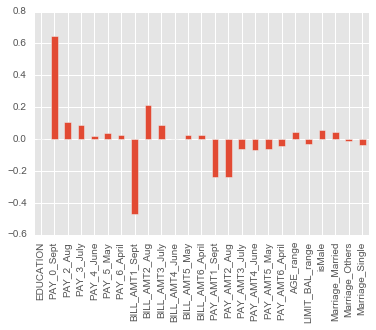

In [15]:
# Graph the coeficients to find the standout features
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

weights = pd.Series(logit_coef_scaled_avg[0],index=cc_data_Xs_names)
weights.plot(kind='bar')
plt.show()

# [30 points] Use the weights from logistic regression to interpret the importance of different features for each classiﬁcation task. Explain your interpretation in detail. Why do you think some variables are more important?

# [Insert interpretation here] 


## Support Vector Machine - Using SGDClassifier

In [49]:
# Create New Cross Validation object
cv_object = ShuffleSplit(n=len(cc_data_target), n_iter=10, test_size  = 0.2)

# Initial fixed parmeters
model = SGDClassifier(loss='hinge', n_iter=1, learning_rate='optimal')

# Parameteres to search on:
alpha_values = [.1,1,10,100,1000]
params = {'penalty':('l1','l2'), 
          'alpha':alpha_values, 
          'fit_intercept':(True, False)}

# Run grid search with cv_object
sgd_clf = grid_searcher(model, params, cv_object)

In [50]:
# Print grid serach results
print("The best estimator: ",sgd_clf.best_estimator_)
print("The best accuracy score is: ", sgd_clf.best_score_)
print("The best parameters of model is: ",sgd_clf.best_params_)

The best estimator:  SGDClassifier(alpha=0.1, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=False, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=1, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
The best accuracy score is:  0.7655
The best parameters of model is:  {'alpha': 0.1, 'fit_intercept': False, 'penalty': 'l2'}


In [51]:
### Run best model from grid search to get the coefficients from scaled data for interpretation
sgd_coef_scaled = full_classify(cc_data_target, cc_data_Xs, cv_object, sgd_clf.best_estimator_, scale=True)

# model = SVC(C=0.05, kernel='linear', degree=3, gamma='auto')
# full_classify(cc_data_target, cc_data_Xs, cv_object, model, scale=True)

C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 0  ====
accuracy 0.5775
confusion matrix
 [[2524 2126]
 [ 409  941]]
Classification Report:
              precision    recall  f1-score   support

          0       0.86      0.54      0.67      4650
          1       0.31      0.70      0.43      1350

avg / total       0.74      0.58      0.61      6000

ROC Score 
 0.619916367981


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 1  ====
accuracy 0.583166666667
confusion matrix
 [[2570 2150]
 [ 351  929]]
Classification Report:
              precision    recall  f1-score   support

          0       0.88      0.54      0.67      4720
          1       0.30      0.73      0.43      1280

avg / total       0.76      0.58      0.62      6000

ROC Score 
 0.635136387712


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 2  ====
accuracy 0.616166666667
confusion matrix
 [[2746 1941]
 [ 362  951]]
Classification Report:
              precision    recall  f1-score   support

          0       0.88      0.59      0.70      4687
          1       0.33      0.72      0.45      1313

avg / total       0.76      0.62      0.65      6000

ROC Score 
 0.655085666614


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 3  ====
accuracy 0.579333333333
confusion matrix
 [[2542 2148]
 [ 376  934]]
Classification Report:
              precision    recall  f1-score   support

          0       0.87      0.54      0.67      4690
          1       0.30      0.71      0.43      1310

avg / total       0.75      0.58      0.62      6000

ROC Score 
 0.627490681814


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 4  ====
accuracy 0.587833333333
confusion matrix
 [[2611 2058]
 [ 415  916]]
Classification Report:
              precision    recall  f1-score   support

          0       0.86      0.56      0.68      4669
          1       0.31      0.69      0.43      1331

avg / total       0.74      0.59      0.62      6000

ROC Score 
 0.623712373715


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 5  ====
accuracy 0.602833333333
confusion matrix
 [[2696 1981]
 [ 402  921]]
Classification Report:
              precision    recall  f1-score   support

          0       0.87      0.58      0.69      4677
          1       0.32      0.70      0.44      1323

avg / total       0.75      0.60      0.64      6000

ROC Score 
 0.636291506126


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 6  ====
accuracy 0.599666666667
confusion matrix
 [[2612 2019]
 [ 383  986]]
Classification Report:
              precision    recall  f1-score   support

          0       0.87      0.56      0.69      4631
          1       0.33      0.72      0.45      1369

avg / total       0.75      0.60      0.63      6000

ROC Score 
 0.642129397923


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 7  ====
accuracy 0.587833333333
confusion matrix
 [[2540 2128]
 [ 345  987]]
Classification Report:
              precision    recall  f1-score   support

          0       0.88      0.54      0.67      4668
          1       0.32      0.74      0.44      1332

avg / total       0.76      0.59      0.62      6000

ROC Score 
 0.642560619746


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SCALED DATA

====Iteration 8  ====
accuracy 0.595666666667
confusion matrix
 [[2647 2017]
 [ 409  927]]
Classification Report:
              precision    recall  f1-score   support

          0       0.87      0.57      0.69      4664
          1       0.31      0.69      0.43      1336

avg / total       0.74      0.60      0.63      6000

ROC Score 
 0.630700434466
SCALED DATA

====Iteration 9  ====
accuracy 0.597666666667
confusion matrix
 [[2677 1991]
 [ 423  909]]
Classification Report:
              precision    recall  f1-score   support

          0       0.86      0.57      0.69      4668
          1       0.31      0.68      0.43      1332

avg / total       0.74      0.60      0.63      6000

ROC Score 
 0.627955719215
done. It took 3.3061890602111816 seconds.


C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [52]:
sgd_coef_scaled

[array([[-0.00264616,  0.45161122,  0.15136894,  0.07683781,  0.04501842,
          0.02368433, -0.02231558, -0.09493934, -0.03398594, -0.01812355,
         -0.0053718 ,  0.00646641,  0.01511749, -0.03860175, -0.0465217 ,
          0.00404192, -0.05556664, -0.00715846, -0.03060742,  0.03275371,
         -0.05220305,  0.04052421,  0.02475951,  0.02414389, -0.03017351]]),
 array([[-0.04151041,  0.43844066,  0.16062669,  0.09193812,  0.0388665 ,
          0.027924  ,  0.01187882, -0.09912137, -0.04789439, -0.02090932,
         -0.01118565,  0.0022525 ,  0.00265292, -0.05447243, -0.04582361,
         -0.02646752, -0.00288976, -0.02386755, -0.02536656,  0.04332893,
         -0.03319693,  0.06662092,  0.00912129,  0.01947704, -0.0134333 ]]),
 array([[-0.01982022,  0.46629511,  0.14110001,  0.08558011,  0.03190046,
          0.01778007, -0.00239505, -0.10552806, -0.05174978, -0.03476413,
         -0.01230294,  0.0010449 ,  0.01379671, -0.04774821, -0.05421833,
         -0.02169292, -0.0333277

In [53]:
# Below averages the coeficients of the cross validations
sgd_coef_scaled_avg = np.array(np.mean( sgd_coef_scaled, axis=0 ))
sgd_coef_scaled_avg

array([[-0.0220709 ,  0.438846  ,  0.14957971,  0.08471708,  0.0421959 ,
         0.02675849,  0.00160996, -0.10674511, -0.0476227 , -0.02700446,
        -0.01180886, -0.00214159,  0.0008567 , -0.05251218, -0.03705526,
        -0.01685075, -0.02862258, -0.0273525 , -0.01671281,  0.04742095,
        -0.04339796,  0.05536775,  0.02862363,  0.00514222, -0.0297444 ]])

In [54]:
# Sanity check to make sure the column name list is the same length as the coefficients
print("Coefficients and column names same length: " + str(len(sgd_coef_scaled_avg.T)==len(cc_data_Xs_names)))
print()

# print coefficients with label
zip_vars = zip(sgd_coef_scaled_avg.T,cc_data_Xs_names) # combine attributes
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

Coefficients and column names same length: True

EDUCATION has weight of -0.0220709030703
PAY_0_Sept has weight of 0.438846004543
PAY_2_Aug has weight of 0.149579709669
PAY_3_July has weight of 0.0847170797863
PAY_4_June has weight of 0.042195895799
PAY_5_May has weight of 0.0267584932147
PAY_6_April has weight of 0.00160996230871
BILL_AMT1_Sept has weight of -0.106745111651
BILL_AMT2_Aug has weight of -0.0476227039281
BILL_AMT3_July has weight of -0.0270044565455
BILL_AMT4_June has weight of -0.0118088555582
BILL_AMT5_May has weight of -0.00214158798271
BILL_AMT6_April has weight of 0.000856700581133
PAY_AMT1_Sept has weight of -0.0525121842425
PAY_AMT2_Aug has weight of -0.0370552593966
PAY_AMT3_July has weight of -0.0168507527283
PAY_AMT4_June has weight of -0.0286225810798
PAY_AMT5_May has weight of -0.0273524999233
PAY_AMT6_April has weight of -0.0167128072348
AGE_range has weight of 0.0474209534673
LIMIT_BAL_range has weight of -0.0433979572667
isMale has weight of 0.055367748108

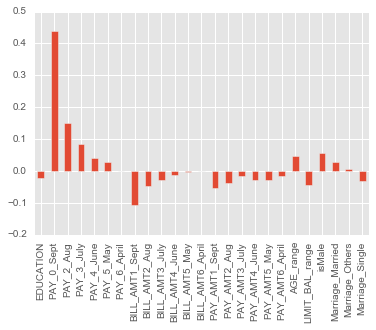

In [55]:
# Graph the coeficients to find the standout features
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

weights = pd.Series(sgd_coef_scaled_avg[0],index=cc_data_Xs_names)
weights.plot(kind='bar')
plt.show()